# GenVeg Main Script
## Test dune vegetation implementation
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new Landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
import matplotlib.pyplot as plt
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file
from noaa_coops import Station

### Define time controls

This sets up a one-year run with a daily timestep.

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=1640

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Dune_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize','dispersal','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 4, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01}, 'root_to_leaf': {'a': 0.031, 'b1': 0.951, 'b2': 0}, 'root_to_stem': {'a': -0.107, 'b1': 1.09

D:\Python\landlab\landlab\components\genveg\load_veg_params.py:251: RuntimeWarning: overflow encountered in exp
  return 1/(1+a*np.exp(-b*x))


### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
env_fname='data\POWER_Point_Daily_20091231_20151230_039d81N_074d09W_LST.csv'
env_data_file=Path(env_fname).absolute()
env_data=np.genfromtxt(env_fname, dtype={'names': ('year','doy','par_Wm^-2','temp_C','precip_mm','root_sm','wind_sp','wid_dir'),'formats': ('int', 'int', 'f8', 'f8','f8', 'f8', 'f8', 'f8', 'f8')}, delimiter=',', skip_header=16) 

AC=Station(id=8534720)
df_water_levels = AC.get_data(
    begin_date="20100101",
    end_date="20151231",
    product="water_level",
    datum="MSL",
    units="metric",
    time_zone="lst")

df_water_levels.head()



#df_water_levels=pd.read_csv(water_levelfilename)
daily_wl=df_water_levels.resample('D').mean()
daily_wl.to_csv('D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv', index=False)

In [6]:

water_levelfilename='D:\\Python\\landlab\\notebooks\\GenVeg\\data\\water_level.csv'
df_water_levels=pd.read_csv(water_levelfilename)
df_water_levels.interpolate(method='linear', inplace=True)
df_WL_MA=df_water_levels.rolling(7)
water_level=df_water_levels['v'].to_numpy()
print(water_level.max())

1.2357375


In [7]:
grid_elev=np.array([
-0.1928368,0.002336806,0.2527808,0.4474464,0.7190232,0.9187687,1.215136,1.431138,1.687068,1.882648,2.092655,2.256739,2.479954,2.701747,2.986938,3.585566,4.65267,5.686654,6.538773,6.87446,6.985254,6.662318,6.724193,6.803441,6.915912,6.745834,6.621476,6.344412,6.305398,5.864048,
-0.2033016,0.027432,0.18288,0.5480304,0.6114288,0.9976104,1.147267,1.50053,1.645615,1.915058,2.08727,2.275637,2.40731,2.756916,2.941015,3.262884,4.552798,6.14233,6.364834,7.109155,7.149389,7.020154,6.970167,7.130491,6.918655,6.73608,6.69798,6.50108,6.321552,6.105145,
-0.2182368,0.0393192,0.2023872,0.4745736,0.5544312,1.008888,1.149401,1.504188,1.655369,1.89799,2.105558,2.306422,2.464308,2.789225,2.94894,3.213202,3.951427,6.163666,6.351727,7.000341,7.175601,7.028993,7.013144,7.004914,6.978701,6.901891,6.844589,6.463894,6.34106,6.149035,
-0.2584704,0.04572,0.1524,0.5205984,0.6096,1.023214,1.21158,1.479499,1.655064,1.98882,2.197913,2.396033,2.558186,2.817876,2.870911,3.130601,3.53629,6.078321,6.180735,6.859829,7.010096,6.894271,6.924751,6.959194,6.890614,6.94944,6.938772,6.399886,6.315761,5.94299,
-0.2237232,0.0972312,0.2292096,0.6007608,0.6184392,1.099414,1.258824,1.589837,1.754734,2.036369,2.161032,2.415235,2.610307,2.827325,2.948635,3.154985,3.353714,5.825033,6.157265,6.656832,6.97992,6.921399,6.939686,6.915607,6.85739,6.900063,6.892138,6.430975,6.267298,6.002427,
-0.1801368,0.0420624,0.2493264,0.6403849,0.7501128,1.154278,1.332891,1.666037,1.870558,2.173529,2.342693,2.512771,2.677363,2.792273,2.871216,3.112008,3.324454,5.696407,6.104535,6.589167,6.720231,7.064045,6.970777,6.856476,6.872326,6.702247,6.476696,6.156655,6.049366,5.864048,
-0.2770632,0.07955281,0.25908,0.6525768,0.733044,1.194816,1.418844,1.72974,1.901038,2.156155,2.396642,2.603906,2.683764,2.791358,2.887066,3.043123,3.281172,5.27304,5.968289,6.712001,7.053072,7.083247,6.924447,6.717793,6.733032,6.419088,6.252363,6.051499,5.923179,5.823204,
-0.1917192,0.1277112,0.2688336,0.6504433,0.7318248,1.254557,1.453286,1.86629,2.083918,2.350618,2.504847,2.604211,2.579218,2.731008,2.805989,3.045257,3.231185,4.619244,5.366309,6.59892,7.016191,7.228941,7.070446,6.715049,6.49925,6.117032,5.89026,5.665318,5.719572,5.817413,
-0.2234184,0.1197864,0.2639568,0.6574537,0.7427976,1.26553,1.483157,1.884274,2.062886,2.284171,2.386279,2.538984,2.579827,2.695956,2.793187,3.027883,3.20741,4.701845,5.63819,6.676949,6.959803,7.325868,7.168896,6.741567,6.477305,6.062777,5.837224,5.59308,5.525719,5.715305,
-0.1423416,0.1045464,0.2340864,0.6068568,0.679704,1.160983,1.363675,1.702613,1.874825,2.155546,2.291182,2.488692,2.494788,2.658161,2.73619,2.969971,3.189427,4.169969,5.011827,6.572402,6.876288,7.343546,7.232904,6.787896,6.340755,6.123737,5.990234,5.648859,5.568391,5.678424,
-0.1697736,0.09570721,0.2188464,0.595884,0.6931152,1.106729,1.358494,1.685239,1.825142,2.093671,2.258263,2.427427,2.481377,2.625852,2.703576,3.010509,3.153461,3.971544,4.618939,6.444386,6.772351,7.306361,7.251801,6.769303,6.444691,6.167933,6.059424,5.871363,5.775351,5.783276,
-0.2100072,0.1222248,0.2136648,0.5727192,0.6129528,1.001268,1.169518,1.516075,1.66177,1.968094,2.092147,2.311603,2.407006,2.592019,2.686812,2.942539,3.141574,3.594507,4.324502,6.266993,6.640983,7.199071,7.231076,7.006743,7.032041,6.542227,6.377026,6.12709,6.008828,5.785409,
-0.1880616,0.0841248,0.1831848,0.5376672,0.5574792,0.9506712,1.138733,1.464564,1.635557,1.887626,2.04917,2.27015,2.379574,2.597201,2.691993,2.934005,3.10134,3.496666,4.080053,6.157265,6.567526,7.068312,7.170724,6.912864,6.763817,6.320333,6.27126,6.361176,6.175858,5.765902,
-0.1441704,0.10668,0.225552,0.4453128,0.5047488,0.8388096,1.030529,1.353922,1.529182,1.764487,1.929689,2.136038,2.261616,2.496007,2.599334,2.908097,3.0861,3.317139,3.660648,5.831434,6.19628,6.896405,6.931457,7.434682,7.669378,7.43712,7.25485,6.894881,6.79765,6.512967,
-0.1283208,0.1024128,0.2185416,0.4773168,0.5172456,0.8189976,1.011936,1.277417,1.439875,1.727911,1.981505,2.129942,2.230222,2.451811,2.577693,2.843784,3.031236,3.318358,3.547262,6.124956,6.46938,6.930847,6.975957,7.890053,7.908036,7.556906,7.371284,6.856476,6.771132,6.448044,
-0.0905256,0.050292,0.1557528,0.4261104,0.4959096,0.7805929,0.9086088,1.198778,1.345082,1.6383,1.83703,2.089099,2.189378,2.458517,2.588666,2.82763,3.007157,3.241853,3.374136,6.511747,6.813499,7.29996,7.400239,7.94766,7.881214,7.680655,7.513625,7.075017,6.899148,6.578194,
-0.202692,0.0124968,0.1252728,0.397764,0.4507992,0.740664,0.894588,1.199693,1.360627,1.634338,1.841907,2.107082,2.21681,2.459736,2.562149,2.84226,3.001366,3.224174,3.282696,6.367272,6.526073,7.259117,7.431938,7.716317,7.62762,7.523074,7.359701,7.000037,6.857086,6.583985,
-0.2444496,0.0423672,0.179832,0.416052,0.4605528,0.7187184,0.8476488,1.136904,1.261262,1.632204,1.873301,2.100377,2.210105,2.44541,2.553919,2.756611,2.986735,3.234538,3.317139,6.04266,6.048756,6.913474,7.030517,7.280453,7.214312,6.962547,6.841541,6.68335,6.678778,6.490411,
-0.275844,0.0521208,0.1822704,0.4614672,0.5297424,0.7479792,0.8842248,1.132332,1.320394,1.604162,1.855622,2.139391,2.227479,2.483206,2.586838,2.82001,2.991002,3.145231,3.273247,5.810402,5.782056,6.662928,6.830873,7.204253,7.061606,6.811061,6.686093,6.535827,6.556248,6.465722,
-0.3834384,0.0310896,0.1999488,0.5081016,0.5690616,0.8095488,0.905256,1.231392,1.411529,1.761744,1.985162,2.164385,2.276246,2.540203,2.636215,2.816962,2.952902,3.170834,3.271418,5.628437,5.89788,6.414211,6.508395,6.834835,6.878727,6.734251,6.514185,6.256325,6.227674,6.302959
])
grid_elev.size

600

In [8]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((22, 32), 2, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

#Create dummy datasets of mean monthly temperature, PAR, distance to the shore, and elevation relative to sea level
meantemp=env_data['temp_C']
NJ_avg_par=env_data['par_Wm2']                

#Initialize with a dummy data sets 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')
_ = pg.add_field('elevation__MSL_m', grid_elev, at='cell', units='m_MSL')

_ = pg.add_field('elevation__above_WL', grid_elev-water_level[0], at='cell', units='m')

In [9]:
core_nodes=pg.core_nodes
x=pg.node_axis_coordinates(0)
x=x[core_nodes]
y=pg.node_axis_coordinates(1)
y=y[core_nodes]
z=pg['cell']['elevation__above_WL']
num_rows=np.unique(x)

In [10]:
dist2shore=np.zeros_like(grid_elev)
for row in num_rows:
  row_loc=np.nonzero(x==row)
  row_x=x[row_loc]
  row_y=y[row_loc]
  row_z=z[row_loc]
  inundated=np.nonzero(row_z<0)
  shore_cell_idx=inundated[-1]
  if shore_cell_idx.size <=0:
    m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
    b=row_z[0]-m*row_y[0]
    shore_y=(0-b)/m

  else:
      wet_cell=shore_cell_idx[-1]
      dry_cell=wet_cell+1
      shore_z_wet=row_z[wet_cell]
      shore_y_wet=row_y[wet_cell]
      shore_z_dry=row_z[dry_cell]
      shore_y_dry=row_y[dry_cell]
      m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
      b=shore_z_wet-m*shore_y_wet
      shore_y=(0-b)/m

  shore_dist=row_y-shore_y
  dist2shore[row_loc]=shore_dist
_ = pg.add_field('Distance to shore', dist2shore, at='cell', units='m', clobber=True)


Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Ammophila, 1/2 by Spartina, at single and double planting densities, respectively.

Future iterations will rely on species boundaries and percent cover to initialize the plants.

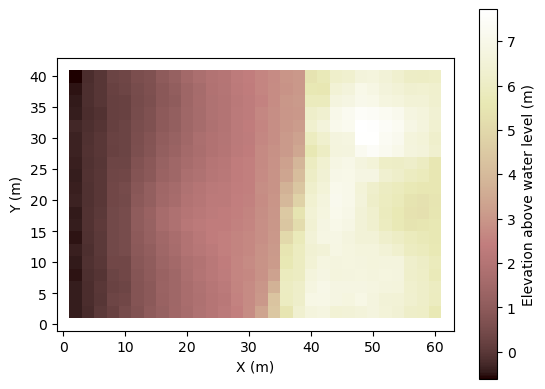

In [11]:
imshow_grid(pg, 'elevation__above_WL', at='cell', colorbar_label='Elevation above water level (m)')

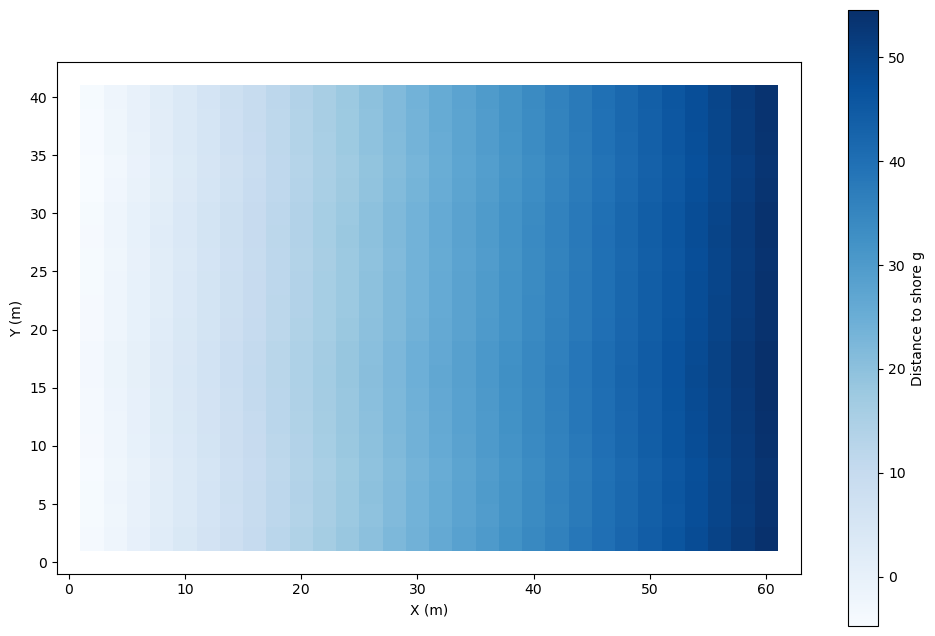

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'Distance to shore', at='cell', colorbar_label='Distance to shore g', cmap='Blues')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_dist2shore.png", dpi=300, bbox_inches="tight")


In [13]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
_ = pg.add_field('vegetation__percent_cover', np.random.default_rng().uniform(low=0.0, high=0.2, size=pg.number_of_cells), at='cell', clobber=True)
plant_list=[['DB','null'],['DB','BTS'],['null','BTS']]
_ = pg.add_field('vegetation__plant_species',np.random.default_rng().choice(plant_list,pg.number_of_cells), at='cell', clobber=True)


pg['cell']['vegetation__plant_species']

### Define model time variables

Initialize dune GenVeg class with veg_params from Excel file

In [14]:
foredune=GenVeg(pg,dt,sim_start_date,vegparams)

In [15]:
print(vegparams)

{'BTS': {'col_params': {'prob_colonization': 0.01, 'time_to_colonization': 365}, 'dispersal_params': {'max_dist_dispersal': 0.4, 'min_size_dispersal': 0.5, 'unit_cost_dispersal': 1.2}, 'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'reproduction_start': 180, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': {'leaf': 1.463, 'reproductive': 1.414, 'root': 1.444, 'stem': 1.513, 'storage': 1.415}, 'growth_max_biomass': 13.899999999999999, 'growth_min_biomass': 0.062222222222222213, 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_max': 0.05, 'plant_part_max': {'leaf': 5.5, 'reproductive': 4, 'root': 4.3, 'stem': 4.1, 'storage': 1}, 'plant_part_min': {'leaf': 0.03, 'reproductive': 0, 'root': 0.01, 'stem': 0.022222222222222223, 'storage': 0.01}, 'respiration_coefficient': {'leaf': 0.03, 'reproductive': 0.01, 'root': 0.015, 'stem': 0.015, 'storage': 0.01}, 'root_to_leaf': {'a': 0.031, 'b1': 0.951, 'b2': 0}, 'root_to_stem': {'a': -0.107, 'b1': 1.09

In [16]:
foredune.get_int_output()

[{'DB': 0.03224548219286226, 'BTS': 0.020196881125925704}, {'DB': 0.071585892903648238, 'BTS': 0.084359053482773533}, {'DB': 0.03127242016751941, 'BTS': 0.021440305984020736}, {'null': 0.0, 'BTS': 0.0034052192795172688}, {'null': 0.0, 'BTS': 0.15429849233693194}, {'null': 0.0, 'BTS': 0.12300189668487836}, {'DB': 0.019053166569841368, 'BTS': 0.02283763700727107}, {'DB': 0.15389508607443256, 'null': 0.0}, {'DB': 0.059724265118105607, 'null': 0.0}, {'null': 0.0, 'BTS': 0.1185354681806875}, {'DB': 0.095825202017487884, 'null': 0.0}, {'null': 0.0, 'BTS': 0.12543439375176066}, {'DB': 0.14254145788406855, 'null': 0.0}, {'DB': 0.061127937527172257, 'BTS': 0.07339695537785082}, {'DB': 0.069008432624628704, 'null': 0.0}, {'null': 0.0, 'BTS': 0.19988484603529702}, {'DB': 0.080339437108134751, 'BTS': 0.086196810742809341}, {'DB': 0.11024835014613538, 'null': 0.0}, {'null': 0.0, 'BTS': 0.16323913790385386}, {'null': 0.0, 'BTS': 0.12839378511083643}, {'DB': 0.15720886709102913, 'null': 0.0}, {'null'

In [17]:
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

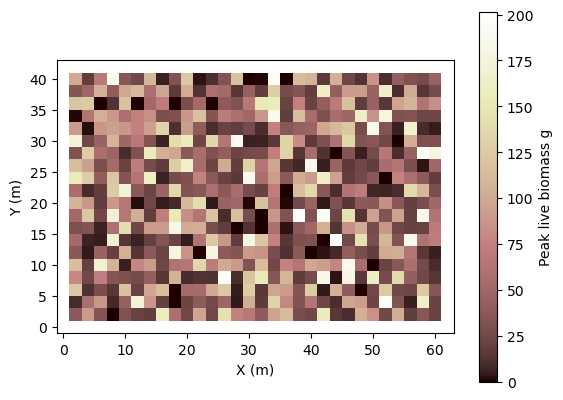

In [18]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Peak live biomass g')

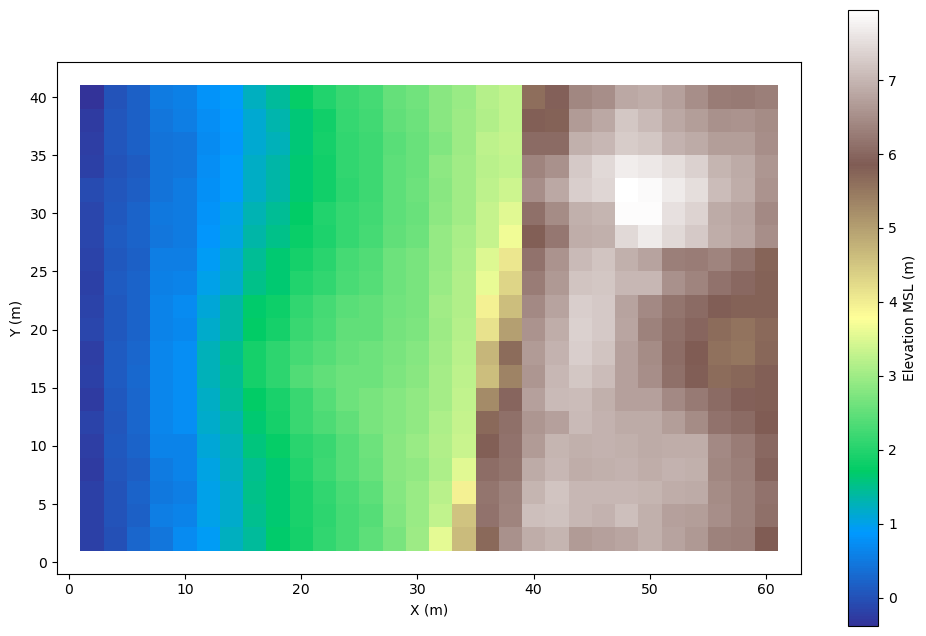

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'elevation__MSL_m', at='cell',colorbar_label='Elevation MSL (m)', cmap='terrain')
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_elevation.png", dpi=300, bbox_inches="tight")

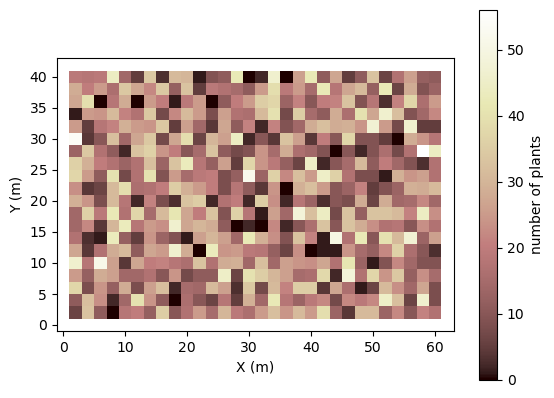

In [20]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

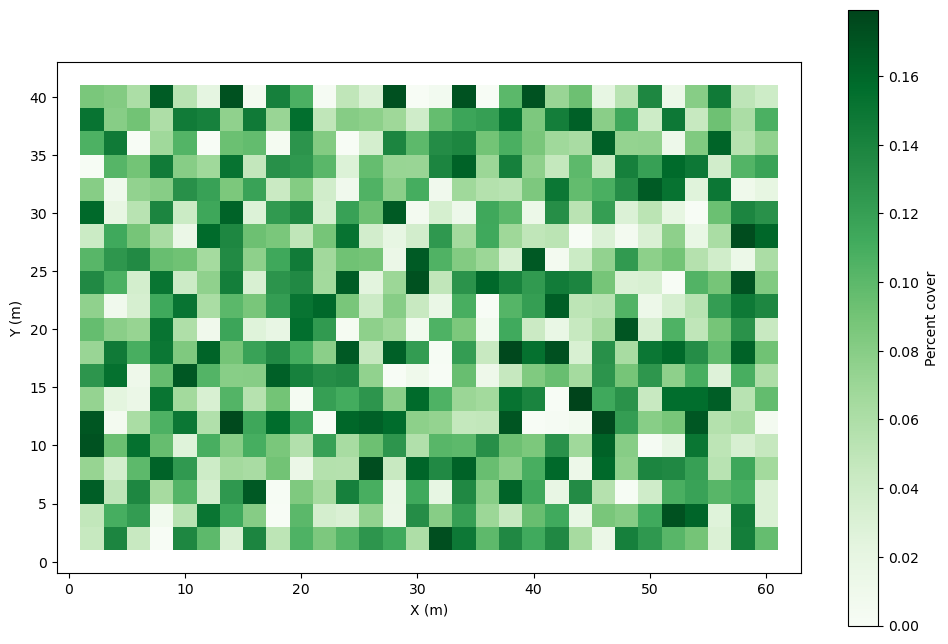

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'vegetation__percent_cover', at='cell', colorbar_label='Percent cover', cmap='Greens')
#ax=plt.gca()
#end_data=pd.concat([DB,BTS], sort=False)
#plant_locs=end_data[['x_loc','y_loc']].to_numpy()
#sizes=end_data['root_sys_width'].values/2
#for idx,center in enumerate(plant_locs):
#    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='green')
#    ax.add_patch(circle)
#plt.show()
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_pcover.png", dpi=300, bbox_inches="tight")

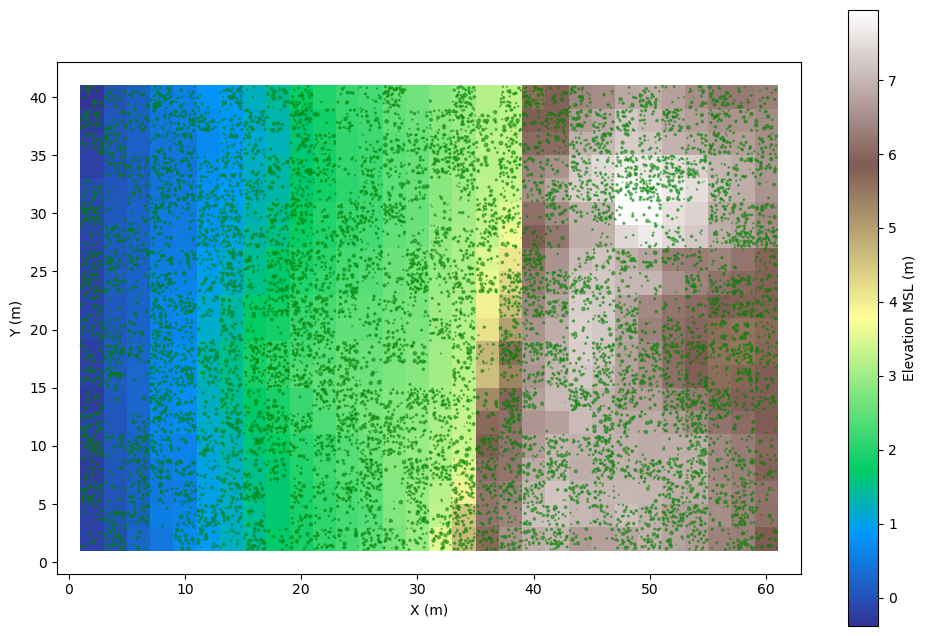

In [22]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'elevation__MSL_m', at='cell', colorbar_label='Elevation MSL (m)', cmap='terrain')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=end_data[['x_loc','y_loc']].to_numpy()
sizes=end_data['root_sys_width'].values/2
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='green')
    ax.add_patch(circle)
plt.show()
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init_plant_dist.png", dpi=300, bbox_inches="tight")

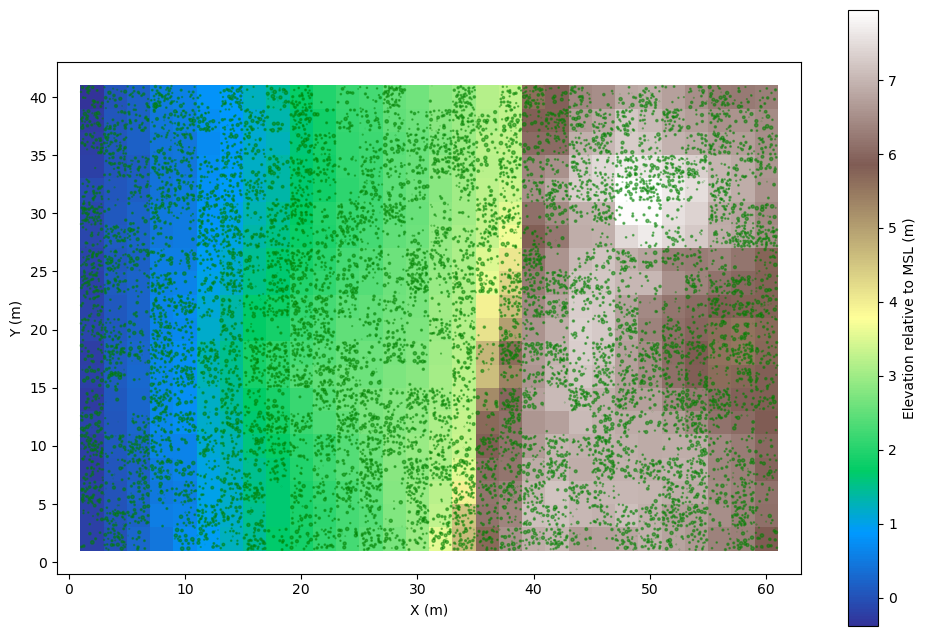

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
imshow_grid(pg, 'elevation__MSL_m', at='cell', colorbar_label='Elevation relative to MSL (m)', cmap='terrain')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=end_data[['x_loc','y_loc']].to_numpy()
sizes=end_data['root_sys_width'].values/2
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='green')
    ax.add_patch(circle)
plt.show()
fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_init.png", dpi=300, bbox_inches="tight")

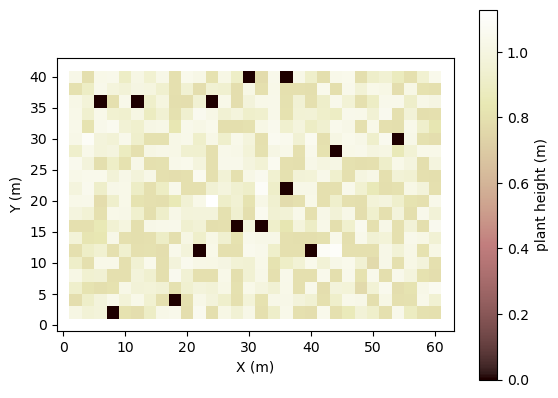

In [24]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)')

pd.DataFrame(foredune.plant_species[1].species_plants())

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

I emerge from dormancy
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing seas

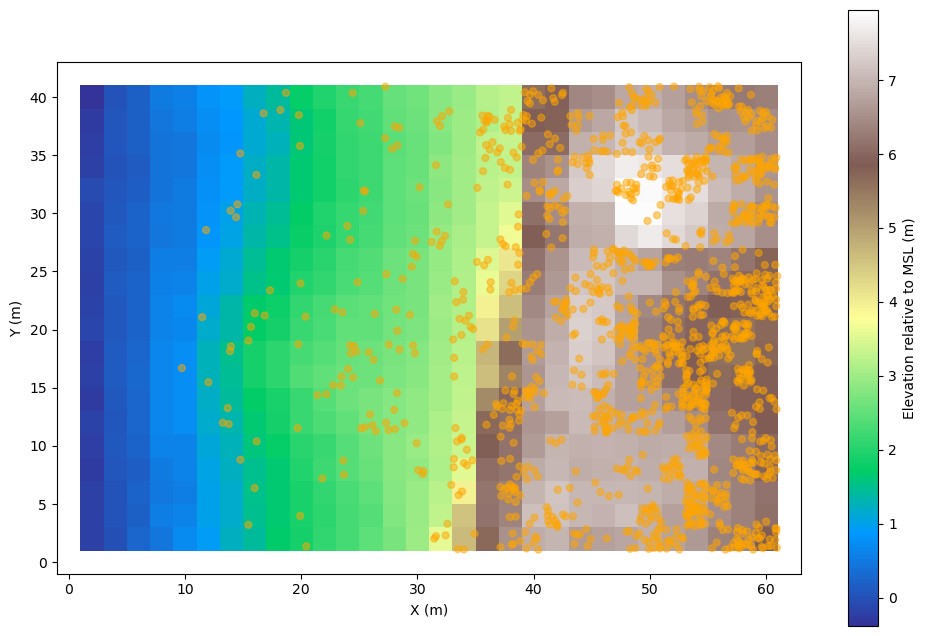

I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizi

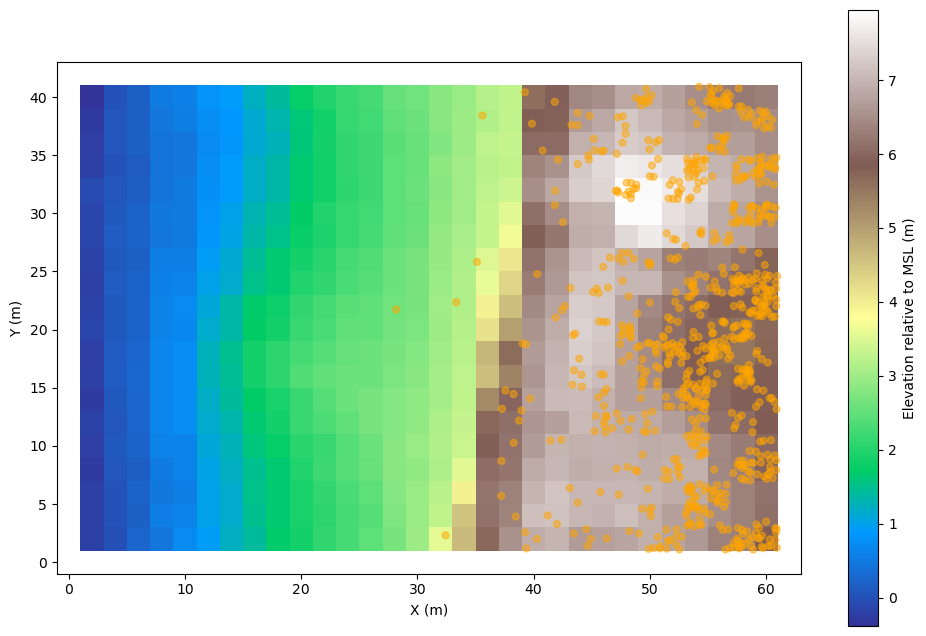

I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizi

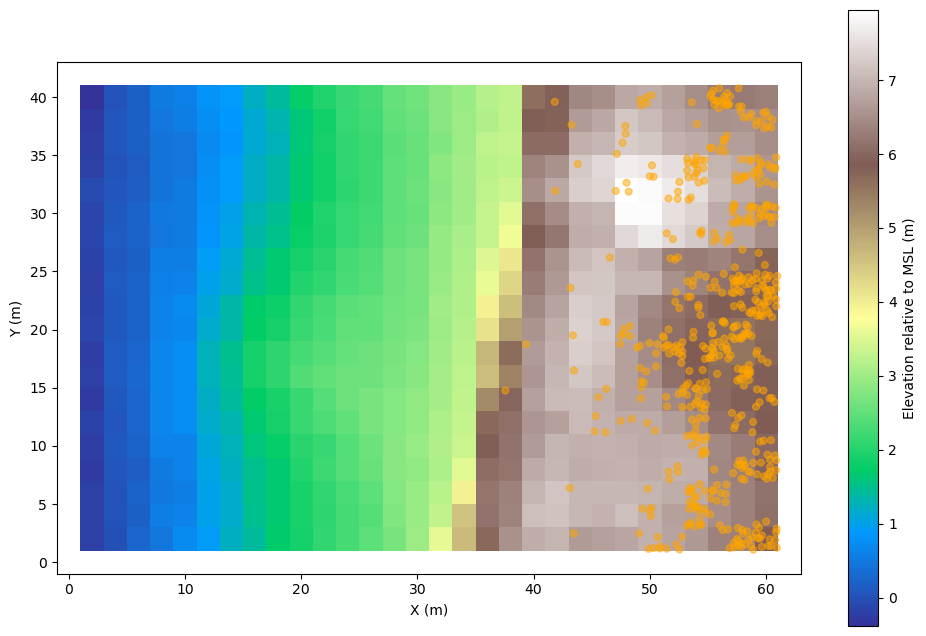

I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizi

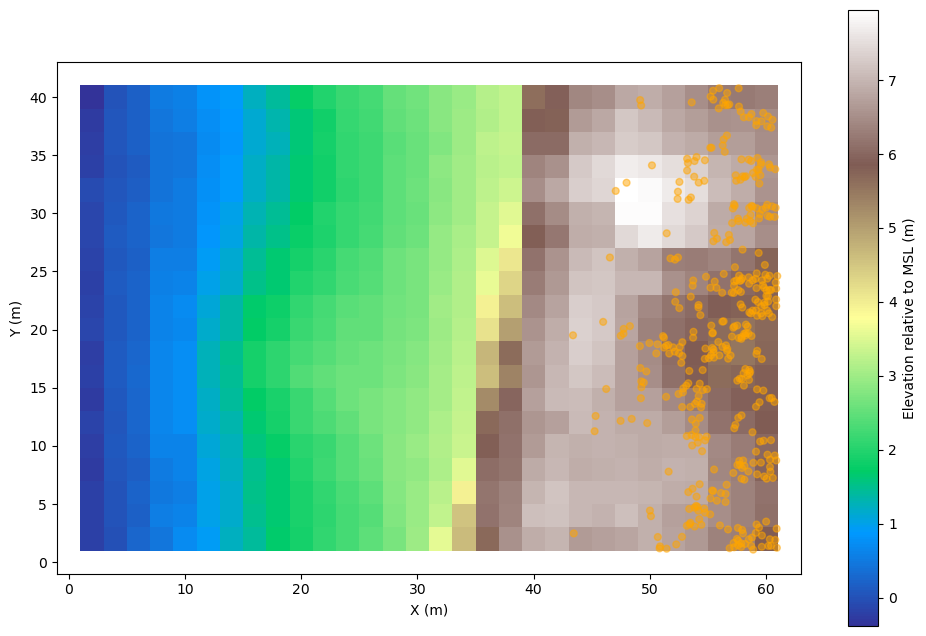

I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizing during the growing season
I am photosynthesizi

In [25]:
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
save_points=[243, 243+365, 243+365+366,243+365+366+365, 243+365+366+365+365]
for i in range(run_length_d):
    #update temp attribute on grid
    pg.at_cell['air__temperature_C']= meantemp[i]*np.ones(pg.number_of_cells)
    pg.at_cell['radiation__par_tot']= NJ_avg_par[i]*np.ones(pg.number_of_cells)
    pg.at_cell['elevation__above_WL']=pg.at_cell['elevation__MSL_m']-(water_level[i]*np.ones(pg.number_of_cells))
    z=pg.at_cell['elevation__above_WL']
    dist2shore=np.zeros_like(grid_elev)
    for row in num_rows:
        row_loc=np.nonzero(x==row)
        row_x=x[row_loc]
        row_y=y[row_loc]
        row_z=z[row_loc]
        inundated=np.nonzero(row_z<0)
        shore_cell_idx=inundated[-1]
        if shore_cell_idx.size<=0:
            m=(row_z[1]-row_z[0])/(row_y[1]-row_y[0])
            b=row_z[0]-m*row_y[0]
            shore_y=(0-b)/m

        else:
            wet_cell=shore_cell_idx[-1]
            dry_cell=wet_cell+1
            shore_z_wet=row_z[wet_cell]
            shore_y_wet=row_y[wet_cell]
            shore_z_dry=row_z[dry_cell]
            shore_y_dry=row_y[dry_cell]
            m=(shore_z_wet-shore_z_dry)/(shore_y_wet-shore_y_dry)
            b=shore_z_wet-m*shore_y_wet
            shore_y=(0-b)/m

        shore_dist=row_y-shore_y
        dist2shore[row_loc]=shore_dist
    pg.at_cell['Distance to shore']=dist2shore
    foredune.run_one_step()
    
    if (i in save_points):
        DB=pd.DataFrame(foredune.plant_species[1].species_plants())
        BTS=pd.DataFrame(foredune.plant_species[0].species_plants())
        fig, ax = plt.subplots(figsize=(12,8)) #figsize in inches
        imshow_grid(pg, 'elevation__MSL_m', at='cell', colorbar_label='Elevation relative to MSL (m)', cmap='terrain')
        ax=plt.gca()
        
        
        plant_locs_db=DB[['x_loc','y_loc']].to_numpy()
        sizes_db=DB['shoot_sys_width'].values
        for idx,center in enumerate(plant_locs_db):
            circle = plt.Circle(center, sizes_db[idx], alpha=0.5, color='blue')
            ax.add_patch(circle)
        plt.show()
        
        plant_locs_bts=BTS[['x_loc','y_loc']].to_numpy()
        sizes_bts=BTS['shoot_sys_width'].values
        for idx,center in enumerate(plant_locs_bts):
            circle = plt.Circle(center, sizes_bts[idx], alpha=0.5, color='orange')
            ax.add_patch(circle)
        plt.show()
        fig.savefig("D:\\Python\\landlab\\notebooks\\GenVeg\\figure_"+str(i)+".png", dpi=300, bbox_inches="tight") # the bbox_inches removes whitespace around the plot

    if (i/28).is_integer():
        foredune.save_output()
        write_netcdf("dune.nc",pg, format="NETCDF3_64BIT",append=True, time=(foredune.current_day-foredune.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants', 'vegetation__percent_cover'])
        #imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)')


In [26]:
output=foredune.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [27]:
output.index.unique(level=2)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7652],
           dtype='int64', name='item_id', length=7653)

In [28]:
output.loc[0, 'DB',:] #timestep,species,plant number in []

,grid_element,element_id,vegetation__root_biomass,vegetation__leaf_biomass,vegetation__stem_biomass,vegetation__storage_biomass,vegetation__repro_biomass,vegetation__plant_age
item_id,,,,,,,,
0,cell,0.0,3.714415,0.0,0.0,0.314999,2.671007,0.0
1,cell,0.0,4.593540,0.0,0.0,0.034576,3.394728,0.0
2,cell,0.0,9.963641,0.0,0.0,0.251157,7.722376,0.0
3,cell,0.0,8.922397,0.0,0.0,0.545269,4.797361,0.0
4,cell,0.0,5.758694,0.0,0.0,0.658570,4.734305,0.0
...,...,...,...,...,...,...,...,...
7648,cell,599.0,4.546063,0.0,0.0,0.018605,6.878566,0.0
7649,cell,599.0,2.936802,0.0,0.0,0.869172,8.812098,0.0
7650,cell,599.0,5.840170,0.0,0.0,0.503329,2.751726,0.0


output.loc[21.0]

In [29]:
pd.set_option('display.max_rows',None)
DB=pd.DataFrame(foredune.plant_species[1].species_plants())
BTS=pd.DataFrame(foredune.plant_species[0].species_plants())

In [30]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


array([ 4.30198152,  0.49876356,  2.3656364 , ...,  5.70932691,
        5.71428764,  5.71037743])

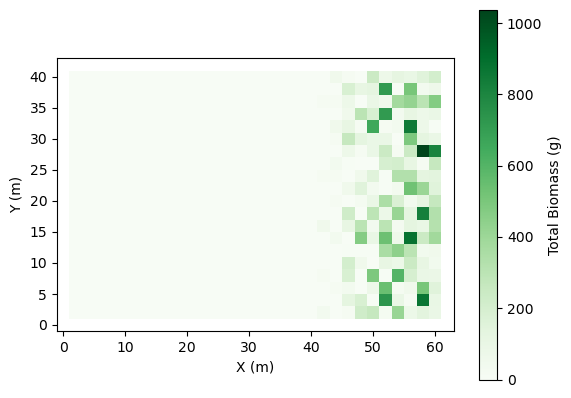

In [31]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Total Biomass (g)', cmap='Greens')

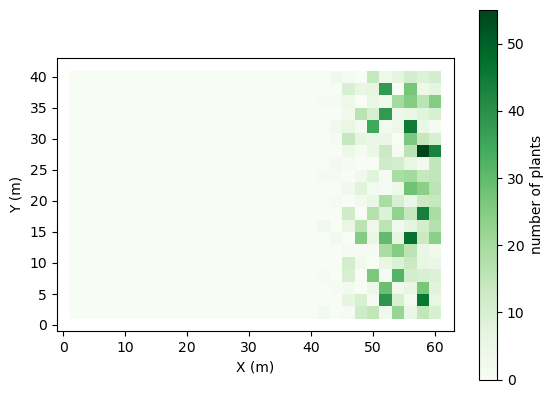

In [32]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants', cmap='Greens')

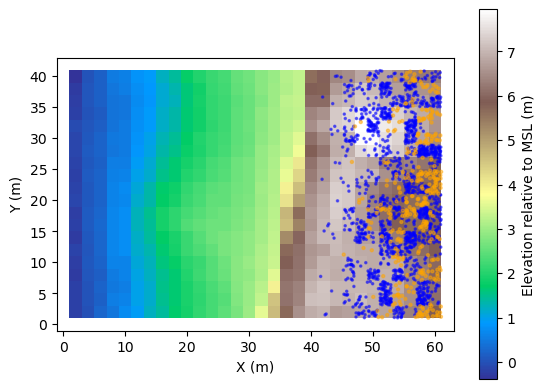

In [33]:
imshow_grid(pg, 'elevation__MSL_m', at='cell', colorbar_label='Elevation relative to MSL (m)', cmap='terrain')
ax=plt.gca()
end_data=pd.concat([DB,BTS], sort=False)
plant_locs=DB[['x_loc','y_loc']].to_numpy()
sizes=DB['shoot_sys_width'].values
   
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='blue')
    ax.add_patch(circle)
plant_locs=BTS[['x_loc','y_loc']].to_numpy()
sizes=BTS['shoot_sys_width'].values
for idx,center in enumerate(plant_locs):
    circle = plt.Circle(center, sizes[idx], alpha=0.5, color='orange')
    ax.add_patch(circle)
plt.show()

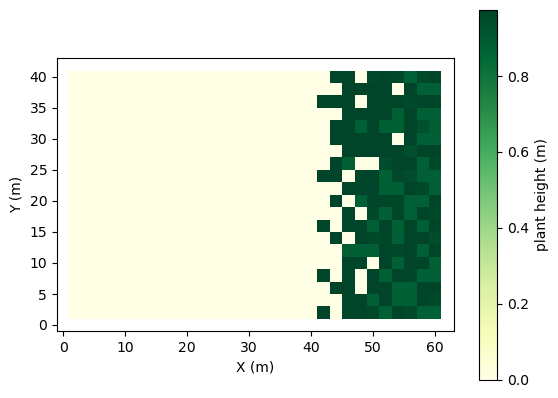

In [34]:
imshow_grid(pg, 'vegetation__plant_height', at='cell', colorbar_label='plant height (m)', cmap='YlGn')

grid.close()